# LR calculation with gaussian and KDE pdf and CLLR validation using 10-fold cross validation

Scores calculated using OpenFace (docker image bamos/openface) on a modified version of the LFW dataset. The known errors of the dataset were corrected and only persons with more than one picture were included. For the remaining images, OpenFace failed to detect a face and were excluded from the analisys.

In [2]:
from scipy.stats import kurtosis, skew, norm
from KDEpy import FFTKDE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
scores = pd.read_csv('scores_lfw2_sim.csv', sep=";", index_col=0)

In [4]:
scores

,Aaron_Peirsol_0001.jpg,Aaron_Peirsol_0002.jpg,Aaron_Peirsol_0003.jpg,Aaron_Peirsol_0004.jpg,Aaron_Sorkin_0001.jpg,Aaron_Sorkin_0002.jpg,Abdel_Nasser_Assidi_0001.jpg,Abdel_Nasser_Assidi_0002.jpg,Abdoulaye_Wade_0001.jpg,Abdoulaye_Wade_0002.jpg,...,Zinedine_Zidane_0001.jpg,Zinedine_Zidane_0002.jpg,Zinedine_Zidane_0003.jpg,Zinedine_Zidane_0004.jpg,Zinedine_Zidane_0005.jpg,Zinedine_Zidane_0006.jpg,Zoran_Djindjic_0001.jpg,Zoran_Djindjic_0002.jpg,Zoran_Djindjic_0003.jpg,Zoran_Djindjic_0004.jpg
Aaron_Peirsol_0001.jpg,0.0,0.88182,0.918922,0.788271,0.329608,0.127099,-0.233390,-0.093396,-0.241151,-0.105503,...,0.391352,0.357897,0.285503,0.335343,0.294585,0.343526,-0.015358,0.151261,0.071529,0.441294
Aaron_Peirsol_0002.jpg,0.0,0.00000,0.916174,0.843587,0.239368,0.105687,-0.061104,0.031432,-0.251871,-0.130869,...,0.507219,0.531519,0.408092,0.486439,0.468126,0.459221,0.098904,0.157093,0.129454,0.497494
Aaron_Peirsol_0003.jpg,0.0,0.00000,0.000000,0.828790,0.395638,0.214128,-0.170250,-0.046550,-0.287656,-0.158988,...,0.463512,0.493310,0.411326,0.426477,0.405614,0.349620,0.071453,0.179081,0.174319,0.431981
Aaron_Peirsol_0004.jpg,0.0,0.00000,0.000000,0.000000,0.182008,0.113329,-0.187707,-0.066894,-0.224509,-0.087455,...,0.508928,0.573537,0.464429,0.389685,0.459720,0.308673,0.165535,0.239776,0.178274,0.526052
Aaron_Sorkin_0001.jpg,0.0,0.00000,0.000000,0.000000,0.000000,0.854894,-0.140922,0.070133,0.079384,0.063131,...,0.213127,0.365448,0.346256,0.334905,0.305944,0.305582,0.270074,0.339990,0.434063,0.331451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zinedine_Zidane_0006.jpg,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091648,-0.039693,0.063322,0.386164
Zoran_Djindjic_0001.jpg,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.901121,0.865758,0.705540
Zoran_Djindjic_0002.jpg,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.843541,0.708043
Zoran_Djindjic_0003.jpg,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.621923


In [5]:
filenames = scores.index.to_numpy()
print(filenames)

['Aaron_Peirsol_0001.jpg' 'Aaron_Peirsol_0002.jpg'
 'Aaron_Peirsol_0003.jpg' ... 'Zoran_Djindjic_0002.jpg'
 'Zoran_Djindjic_0003.jpg' 'Zoran_Djindjic_0004.jpg']


Separar scores ss e ds, sem perder a referência dos nomes e descartando as duplicidades.

In [6]:
def same(a,b):
    a=os.path.splitext(a)[0]
    a_name = a[:-5]
    b=os.path.splitext(b)[0]
    b_name = b[:-5]
    if a_name == b_name:
        return True
    else:
        return False

ss=[]
ds=[]
s_names=[]
d_names=[]
# for loops to check only upper half of the scores matrix, without diagonal -> won't get any scores of identical files.
# Check if files are from same person or from different persons, according to filename prefix.
for i in range(0,len(filenames)):
    for j in range(i+1,len(filenames)):
        f1 = filenames[i]
        f2 = filenames[j]
        if same(f1,f2):
            ss.append(scores[f2][f1])
            s_names.append([f2,f1])
        else:
            ds.append(scores[f2][f1])
            d_names.append([f2,f1])
print(s_names[0],ss[0])

['Aaron_Peirsol_0002.jpg', 'Aaron_Peirsol_0001.jpg'] 0.8818204


In [7]:
n_ds = len(ds)
n_ss = len(ss)
min_score = min(min(ds),min(ss))
max_score = max(max(ds),max(ss))
print (n_ss,"genuine scores loaded.")
print (n_ds,"impostor scores loaded.")
print ("Minimum score:",min_score)
print ("Maximum score:",max_score)

241268 genuine scores loaded.
41496548 impostor scores loaded.
Minimum score: -0.7790799
Maximum score: 0.9916878


Fit normal distributions to SS and DS scores

In [8]:
bins = np.arange(-1, 1.0000001, 0.005)
ss_hist, _ = np.histogram(ss, bins=bins, density=True)
ds_hist, _ = np.histogram(ds, bins=bins, density=True)
len(ss_hist)

400

In [9]:
x = np.linspace(-1, 1, 400)
ss_mean,ss_std = norm.fit(ss)
ds_mean,ds_std = norm.fit(ds)
ss_norm = norm.pdf(x, ss_mean,ss_std)
ds_norm = norm.pdf(x, ds_mean,ds_std)

Estimate pdf's using KDE

In [10]:
#x = np.linspace(-1, 1, 200)
d_weights = np.arange(len(ds)) + 1
s_weights = np.arange(len(ss)) + 1
estimator = FFTKDE(kernel='biweight', bw='silverman')
#estimator = FFTKDE(kernel='gaussian', bw='ISJ')
#estimator = FFTKDE(kernel='gaussian', bw=0.3)
ss_kde = estimator.fit(ss, weights=s_weights).evaluate(x)
ds_kde = estimator.fit(ds, weights=d_weights).evaluate(x)
ss_kde = estimator.fit(ss).evaluate(x)
ds_kde = estimator.fit(ds).evaluate(x)

<IPython.core.display.Javascript object>


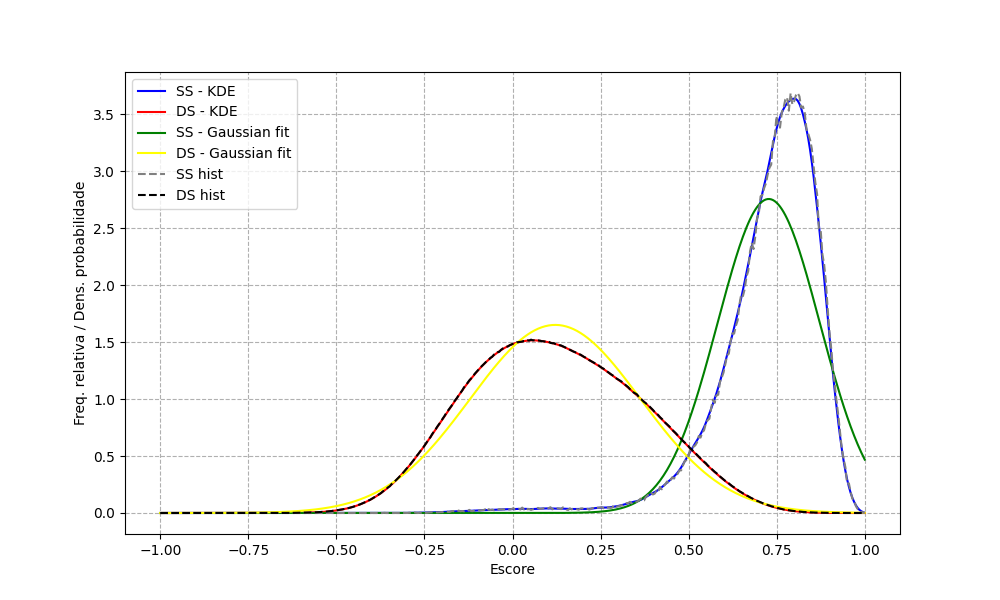

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(x, ss_kde, label='SS - KDE', color='blue')
ax1.plot(x, ds_kde, label='DS - KDE', color='red')
#ax1.hist(ss, bins=int(len(x)/2), alpha=0.3, label="SS Histogram", density=True, color='blue')
#ax1.hist(ds, bins=int(len(x)/2), alpha=0.3, label="DS Histogram", density=True, color='red')
ax1.plot(x,ss_norm, label="SS - Gaussian fit", color="green")
ax1.plot(x,ds_norm, label="DS - Gaussian fit", color="yellow")
ax1.plot(x,ss_hist, label="SS hist", color="gray", linestyle="dashed")
ax1.plot(x,ds_hist, label="DS hist", color="black", linestyle="dashed")
plt.xlabel("Escore")
plt.ylabel("Freq. relativa / Dens. probabilidade")
ax1.grid(True, ls='--'); ax1.legend();
plt.show()

Functions for calculating LR and CLLR

In [13]:
def find_nearest_idx(array, score):
    array = np.asarray(array)
    idx = (np.abs(array - score)).argmin()
    return idx

#def lr(score):
#    idx = find_nearest_idx(x, score)
#    return ss_norm[idx]/ds_norm[idx]
def lr(score, method):
    idx = find_nearest_idx(x, score)
    if method == "kde":
        return ss_kde[idx]/ds_kde[idx]
    elif method == "gauss":
        return ss_norm[idx]/ds_norm[idx]
    else:
        print("Choose one of the two methods: kde or gauss.")
        return None

def get_cllr(lr_ss, lr_ds):
    n_ss = len(lr_ss) 
    n_ds = len(lr_ds)
    cllr_ss = 0
    cllr_ds = 0
    for a in lr_ss:
        cllr_ss += math.log2(1+1/a)
    for b in lr_ds:
        cllr_ds += math.log2(1+b)
    cllr = 0.5*(cllr_ss/n_ss + cllr_ds/n_ds)
    return cllr

In [ ]:
#this is just for debugging
#print(lr(0.6, "gauss"), ss_kde[find_nearest_idx(x,0.6)]/ds_kde[find_nearest_idx(x,0.6)], lr(0.6,"kde") )

Create 10 folds for each group (SS and DS), fit gaussian pdf to train set and compute CLLR for test set.

In [14]:
#p_ss and p_ds = partition sizes for ss and ds sets
p_ss = int(n_ss/10)
p_ds = int(n_ds/10)
ss_test=[]
ds_test=[]
cllr_norm = []
cllr_kde = []
for i in range(0,10):
    ss_test = ss[int(i*p_ss):int((1+i)*p_ss)]
    ds_test = ds[int(i*p_ds):int((1+i)*p_ds)]
    ss_train_a = ss[:int(i*p_ss)]
    ss_train_b = ss[int((1+i)*p_ss):]
    ss_train = np.concatenate((ss_train_a, ss_train_b))
    ds_train_a = ds[:int(i*p_ds)]
    ds_train_b = ds[int((1+i)*p_ds):]
    ds_train = np.concatenate((ds_train_a, ds_train_b))
    
    #generate gaussians PDF from train data
    ss_mean,ss_std = norm.fit(ss_train)
    ds_mean,ds_std = norm.fit(ds_train)
    ss_norm = norm.pdf(x, ss_mean,ss_std)
    ds_norm = norm.pdf(x, ds_mean,ds_std)
    
    #estimate pdf's from train data using KDE
 
    estimator = FFTKDE(kernel='biweight', bw='silverman')
    #estimator = FFTKDE(kernel='gaussian', bw='ISJ')
    #estimator = FFTKDE(kernel='gaussian', bw=0.3)
    ss_kde = estimator.fit(ss_train).evaluate(x)
    ds_kde = estimator.fit(ds_train).evaluate(x)
    
    
    #Compute LR for the test set.
    lr_ss_norm = []
    lr_ds_norm = []
    lr_ss_kde = []
    lr_ds_kde = []
    for score in ss_test:
        lr_ss_norm.append(lr(score,"gauss"))
        lr_ss_kde.append(lr(score,"kde"))
    for score in ds_test:
        lr_ds_norm.append(lr(score,"gauss"))
        lr_ds_kde.append(lr(score,"kde"))
    
    #Compute CLLR for a set of LR values, composed of two arrays (one from matches and one from non_matches)
    cllr_norm.append(get_cllr(lr_ss_norm, lr_ds_norm))
    cllr_kde.append(get_cllr(lr_ss_kde, lr_ds_kde))
    print("\n fold: {} / CLLR(gauss): {:.3f} / CLLR(kde): {:.3f}".format(i,cllr_norm[i],cllr_kde[i]))
    
    #get 5 smallest ss scores and 5 highest ds scores
    #small5 = np.partition(ss_test,5)[:5]
    #high5 = np.partition(ds_test,-5)[-5:]
#    print("5 smallest ss scores:", small5)
#    print("5 highest ds scores:", high5)
cllr_norm_mean = np.mean(cllr_norm)
cllr_norm_dev = np.std(cllr_norm)
cllr_kde_mean = np.mean(cllr_kde)
cllr_kde_dev = np.std(cllr_kde)
print("\nGaussian fit:\nCLLR (mean): {:.3f} / CLLR (std dev): {:.3f}".format(cllr_norm_mean, cllr_norm_dev))
print("\nKDE fit:\nCLLR (mean): {:.3f} / CLLR (std dev): {:.3f}".format(cllr_kde_mean, cllr_kde_dev))


 fold: 0 / CLLR(gauss): 0.323 / CLLR(kde): 0.233

 fold: 1 / CLLR(gauss): 0.257 / CLLR(kde): 0.224

 fold: 2 / CLLR(gauss): 0.246 / CLLR(kde): 0.212


KeyboardInterrupt: 